In [9]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import hist as Hist

In [10]:
def get_number_of_slits(spline_width, pitch, pixels_per_plane):

    '''
        Based on slit parameters, returns how many other slits an energy 
        deposit hit can share with on one side assuming the original hit was in
        center. 
    '''

    a = spline_width - ((pixels_per_plane/2) + pitch)
    b = pixels_per_plane + pitch

    return int(np.floor((a/b) + 1))

In [11]:
def adjacent_slits(pixel, n, pitch = 200, width = 100):
    '''
        Returns the pixel positions of adjacent slits out to n on either side of original
        slit. There is edge case control in this code that may need to be optimized. 
    '''
    slits = []
    for i in range(-n, n + 1):
        if abs(i) < n:
            slits.append(pixel + int(i * (pitch + width)))
        elif i < 0:
                slits.append(pixel + int((i + 1) * (pitch + width) - (pitch + width/2)))
        else:
            slits.append(pixel + int((i - 1) * (pitch + width) + (pitch + width/2)))  
                  
    return slits

In [12]:
def build_spline(hist):
    '''
        Builds a cubic spline to interpolate the energy sharing
        distribution histogram
    '''
    from scipy.interpolate import UnivariateSpline, CubicSpline
    
    centers = hist.axes[0].centers

    amps = hist.values()/np.amax(hist.values())

    spline = CubicSpline(centers, amps, extrapolate = False)

    return spline

In [13]:
ref_data = './BNL_Signal_Response.root'

f = uproot.open(ref_data)

h = f['pmax_histogram'].to_hist()

defaultspline = build_spline(h)

In [14]:
def compute_energy_sharing(atar, entry, spline = defaultspline, pixels_per_plane = 100, pitch = 200, splinewidth = 600):

    '''
    Returns a digitized form atar pixel data in dictionary form
    '''

    output = {
        'pixel_pdg':[],
        'pixel_edep':[],
        'pixel_time':[],
        'pixel_hits':[]
    }


    data = atar.arrays(['pixel_pdg', 'pixel_edep', 'pixel_time', 'pixel_hits'])
    pdg = data['pixel_pdg'][entry]
    edep = data['pixel_edep'][entry]
    time = data['pixel_time'][entry]
    hits = data['pixel_hits'][entry]

 
        
    for i, hit in enumerate(hits):
        #Loop over all hits and calculate energy sharing

        these_energies = []

        places = adjacent_slits(hit, n = 2)
                
        for pos in places:
            energyi = spline(pos - hit) * edep[i]
            these_energies.append(energyi)
        
        #Normalize the energies to conserve energy
        these_energies = np.array(these_energies) * (edep[i]/np.sum(these_energies))

        # print("total Energy", np.sum(these_energies), edep[i])

        output['pixel_edep'] += list(these_energies)
        output['pixel_hits'] += adjacent_slits(hit, n = 2)
        output['pixel_time'] += list(np.full_like(these_energies, time[i]))
        output['pixel_pdg'] += list(np.full_like(these_energies, pdg[i], dtype=int))

    return output

In [15]:
def compute_energy_sharing_all(atar, spline = defaultspline, pixels_per_plane = 100, pitch = 200, splinewidth = 600):

    '''
    Returns a digitized form of all atar pixel data in dictionary form
    '''

    output = {
        'pixel_pdg':[],
        'pixel_edep':[],
        'pixel_time':[],
        'pixel_hits':[]
    }



    #This will go through the entire atar data collection and return a dict of lists for each
    for v in range(len(atar['pixel_edep'].array())):  

        data = atar.arrays(['pixel_pdg', 'pixel_edep', 'pixel_time', 'pixel_hits'])
        pdg = data['pixel_pdg'][v]
        edep = data['pixel_edep'][v]
        time = data['pixel_time'][v]
        hits = data['pixel_hits'][v]

        pdglist = []
        edeplist = []
        timelist = []
        hitslist = []

        for i, hit in enumerate(hits):
            #Loop over all hits and calculate energy sharing

            these_energies = []

            places = adjacent_slits(hit, n = 2)
                    
            for pos in places:
                energyi = spline(pos - hit) * edep[i]
                these_energies.append(energyi)
            
            #Normalize the energies to conserve energy
            these_energies = np.array(these_energies) * (edep[i]/np.sum(these_energies))

            # print("total Energy", np.sum(these_energies), edep[i])

            pdglist += list(np.full_like(these_energies, pdg[i], dtype=int))
            edeplist += list(these_energies)
            timelist += list(np.full_like(these_energies, time[i]))
            hitslist += adjacent_slits(hit, n = 2)

        output['pixel_pdg'].append(pdglist)
        output['pixel_edep'].append(edeplist) 
        output['pixel_time'].append(timelist)
        output['pixel_hits'].append(hitslist)

    return output

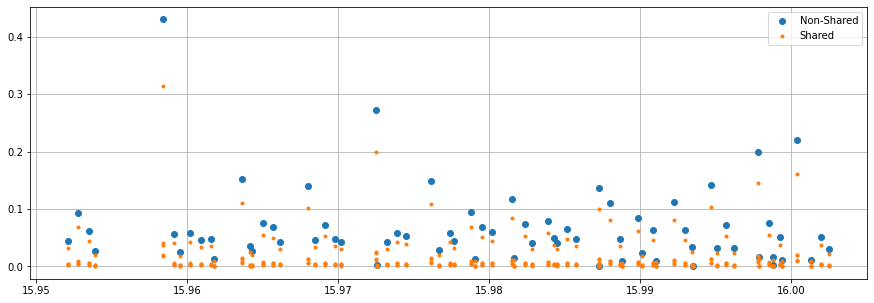

In [17]:
# Here is what my algorithm computes for entry 0


import awkward as ak

atar = uproot.open('/home/dylan/pioneer/simulationdata/pienux_out_stripped.root:atar')

output = compute_energy_sharing(atar, 0)

fig,ax = plt.subplots(figsize=(15,5))
plt.plot(atar['pixel_time'].array()[0], atar['pixel_edep'].array()[0],"o", label='Non-Shared')
plt.plot(output['pixel_time'], output['pixel_edep'],".", label='Shared')

plt.grid()
plt.legend()
plt.show()